## Imports

In [118]:
#import os
#import glob
#import numpy as np
#import math
#import seaborn as sns
#from itertools import chain
#from wordcloud import WordCloud
import sqlite3
import pandas as pd
import matplotlib.pylab as plt
import nltk
import pdftotext
import re

## Variables and IO

In [119]:
parties = ['linke', 'spd', 'grüne', 'cdu', 'fdp', 'afd']
elections = ['bt', 'eu']
colors = {'linke': '#FFC0CB',
          'grüne': '#42923bff',
          'spd':   '#e2001aff',
          'cdu':   '#252422ff',
          'fdp':   '#ffec01ff',
          'afd':   '#009ee0ff'}

def get_pdf_text(party, election):
    with open("../rsc/wahlprogramme/{0}_{1}.pdf".format(party, election), "rb") as f:
        pdf = pdftotext.PDF(f)
        return " ".join(pdf)

## Text cleanup

In [120]:
def get_filtered(text):
    replaced = re.sub('\W*-\\n\W*', '', text)
    replaced = re.sub('\W*\\n\W*', ' ', replaced)
    replaced = re.sub('\d+', ' ', replaced)
    return re.sub('\W+', ' ', replaced)

## Stop words

In [135]:
from nltk.corpus import stopwords
stop = set(stopwords.words('german'))

## Lemmatization

In [122]:
from spacy.lang.de import lemmatizer
from treetaggerwrapper import TreeTagger, TreeTaggerError
from enchant import Dict
dic = Dict("de_DE")

tagger = TreeTagger(TAGLANG='de')

def lemmatize_spacy(word):
    spacy_lower, spacy_cap = (None,None)
    try:
        spacy_lower = lemmatizer.LOOKUP[word.lower()]
    except: pass
    try:
        spacy_cap = lemmatizer.LOOKUP[word.capitalize()]
    except: pass
    if spacy_cap is not None:
        return spacy_cap
    elif spacy_lower is not None:
        return spacy_lower
    else: return None
    
def lemmatize_tt(word):
    wl, wc = word.lower(), word.capitalize()
    tt_lower = tagger.tag_text([wl], tagonly=True)[0].split('\t')[-1]
    tt_cap = tagger.tag_text([wc], tagonly=True)[0].split('\t')[-1]
    if tt_cap != wc:
        return tt_cap
    elif tt_lower != wl:
        return tt_lower
    else: return None

## Word filter

In [92]:
def word_filter(word):
    if word.lower() in stop or word.capitalize() in stop or len(word) <= 2 or not word.isalpha():
        return None
    spacey = lemmatize_spacy(word)
    tt = lemmatize_tt(word)
    if spacey is not None and tt is not None:
        if spacey == tt:
            return tt
        else:
            return spacey
    if spacey is not None:
        return spacey
    if tt is not None:
        return tt
    if dic.check(word.capitalize()) or dic.check(word.lower()):
        return word
    if len(word) > 5 and word.istitle():
        return word
    return None

## Start Processing Chain

In [64]:
dic_raw = {party: {election: get_pdf_text(party, election) for election in ['bt', 'eu']} for party in parties}

In [129]:
def corpus(party, election):
    filtered = get_filtered(dic_raw[party][election])
    for word in filtered.split():
        result = word_filter(word)
        if result is not None:
            yield result
        

<BarContainer object of 6 artists>

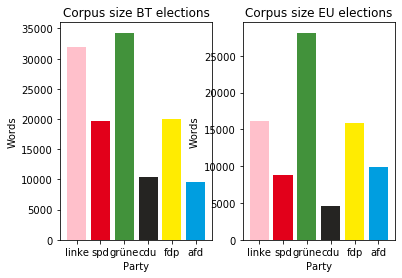

In [133]:
# Corpus size
plt.subplot(1,2,1)
plt.ylabel("Words")
plt.xlabel("Party")
plt.title("Corpus size BT elections")
plt.bar(parties,
        [len(list(corpus(party, 'bt'))) for party in parties],
        color=[colors[party] for party in parties])
plt.subplot(1,2,2)
plt.ylabel("Words")
plt.xlabel("Party")
plt.title("Corpus size EU elections")
plt.bar(parties,
        [len(list(corpus(party, 'eu'))) for party in parties],
        color=[colors[party] for party in parties])

In [128]:
def tfidf(fdists, name):
    """Term frequency - inverse document frequency."""

    def tf(token, fdist):
        return 0.5 + (0.5 * fdist.get(token))/fdist.most_common(1)[0][1]

    def idf(token):
        return math.log2(len(corpus)/(sum(1 for key in fdists.keys() if fdists.get(key).get(token) is not None)))
    fdist = fdists.get(name)
    return [(token, tf(token, fdist) * idf(token)) for token in fdist.keys()]


In [134]:
# Word frequency
fdists = {party: {election: nltk.FreqDist(corpus(party, election)) for election in elections} for party in parties}

In [ ]:
# TF-IDF
tfidfs = {party: tfidf(fdists, party) for party in parties}
#my_weights = {party: my_weighting(fdists, party) for party in parties}

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 30))
axis = chain.from_iterable(zip(*axs))
for party, ax in zip(parties, axis):
    ax.axis("off")
    ax.set_title(party.upper())
    word_weights = sorted(
        tfidfs[party], reverse=True, key=lambda x: x[1])[:30]
    wordcloud = WordCloud(background_color='white', max_font_size=25, height=100).generate_from_frequencies(
        dict(word_weights))
    ax.imshow(wordcloud, interpolation='bilinear')


